# First Auto-Encoder Model
---
In the previous examples we were trying to predict a label, the fraud flag, for the transactions. This is one of the most typical scenario's in the financial crime space and for more traditional machine learning. With Neural Nets we are not limited to only predicting a single class or single label for that matter. We could for instance try to predict the original input.

The auto-encoder architecture is an architecture where the input is condensed into a **latent represenation** by an `encoder`. That latent represenation is then expanded again by a `decoder` into a 'reconstructed input'. It is a funnel of sorts; the input data is first compressed into the latent space and then decompressed. This forces the model to learn usefull representations of the data.

By measuring the loss between the original input and the reconstructed input we can get a feel of how good the model is at reconstructing. If the loss is low and the model is any good at its job, then a low loss probably means it's an input the model has seen a lot during training. Then the sample is a probably fairly normal. If on the other hand the loss is large, then the model did not do such a good job of reconstruction, which could be because it is an anomalous sample.

This may seem a bit trivial at first, but these models have the very usefull property that they do not need a specific *fraud* label, we just predict the input, so any input will do, the input does not need to be classified/labelled. It's almost like an unsupervised set-up. (Though not fully, this is still predictive modelling, with the input as label) In the financial crime world, we are faced with heavily unbalanced data (based on the fraud label), so auto-encoder models might prove usefull for anomaly detection and in semi-supervised/transfer learning setups.

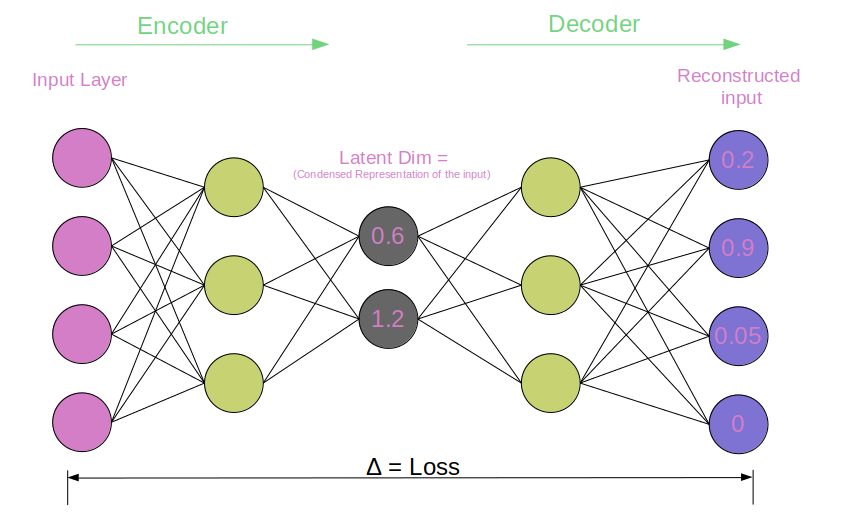

In this first notebook we will have a stab at a simple auto-encoder to do anomaly detection. We will train an auto encoder to reconstruct the output of **non-fraudulent transactions only** and then see if the model has more trouble reconstructing fraudulent transactions in a test phase. By not showing it any fraud we would hope the fraud cases are going to incur a bigger loss.

## Requirements
Before running the experiment, make sure to import the `numpy`, `pandas` and `numba`, `torch`, `tqdm`, `matplotlib`, `scikit-learn`, `captum` packages in your virtual environment
```
> pip install numpy
> pip install pandas
> pip install numba
> pip install torch
> pip install tqdm
> pip install matplotlib
> pip install scikit-learn
> pip install captum
```
And that the notebook can find the `f3atur3s`, `eng1n3` and `m0d3l` packages.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import f3atur3s as ft
import eng1n3.pandas as en
import m0d3l.pytorch as mp
import m0d3l.plot as mplt

import m0d3l.captum as cp

from captum.attr import IntegratedGradients

from typing import Tuple

/home/toms/Jupyter/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set a random seed for Numpy and Torch
Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
## Set up the devices, on from the data and one for modeling.
data_device  = torch.device('cpu')
model_device = torch.device('cuda') if torch.cuda.is_available() else data_device

## File Location
Change this to read from another location

In [4]:
file = '../../../../data/bs140513_032310.csv'

## Define Features
All features for this model are set up as `FeatureOneHot`, which will make our models encode them as a **OneHot** vector. 

Other than in the previous examples we also encode the **amount** as One-Hot vector, we do this by first turning it into a `FeatureBin` and then one-hot encoding the binned feature.

We also define the fraud-label but we will only be using it for the tesing phase. The fraud label is **not used during training**.

In [5]:
age      = ft.FeatureSource('age', ft.FEATURE_TYPE_CATEGORICAL)
gender   = ft.FeatureSource('gender', ft.FEATURE_TYPE_CATEGORICAL)
merchant = ft.FeatureSource('merchant', ft.FEATURE_TYPE_CATEGORICAL)
category = ft.FeatureSource('category', ft.FEATURE_TYPE_CATEGORICAL)
amount   = ft.FeatureSource('amount', ft.FEATURE_TYPE_FLOAT)
fraud    = ft.FeatureSource('fraud', ft.FEATURE_TYPE_INT_8)

amount_binned = ft.FeatureBin('amount_bin', ft.FEATURE_TYPE_INT_16, amount, 30)

amount_oh   = ft.FeatureOneHot('amount_one_hot', ft.FEATURE_TYPE_INT_8, amount_binned)
age_oh      = ft.FeatureOneHot('age_one_hot', ft.FEATURE_TYPE_INT_8, age)
gender_oh   = ft.FeatureOneHot('gender_one_hot', ft.FEATURE_TYPE_INT_8, gender)
merchant_oh = ft.FeatureOneHot('merchant_one_hot', ft.FEATURE_TYPE_INT_8, merchant)
category_oh = ft.FeatureOneHot('category_one_hot', ft.FEATURE_TYPE_INT_8, category)
fraud_label = ft.FeatureLabelBinary('fraud_label', ft.FEATURE_TYPE_INT_8, fraud)

# TensorDefinitions
td_oh    = ft.TensorDefinition('one-hot', [amount_oh, age_oh, gender_oh, merchant_oh, category_oh])
td_label = ft.TensorDefinition('label', [fraud_label])

with en.EnginePandas() as e:
    ti = e.np_from_csv((td_oh, td_label), file, inference=False)

print(ti.shapes)
print(ti.dtype_names)

2023-05-07 12:42:22.775 eng1n3.common.engine           INFO     Start Engine...
2023-05-07 12:42:22.776 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-05-07 12:42:22.776 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-05-07 12:42:22.777 eng1n3.pandas.pandasengine     INFO     Building Panda for : All_r_1 from file ../../../../data/bs140513_032310.csv
2023-05-07 12:42:23.251 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: All_r_1
2023-05-07 12:42:23.290 eng1n3.pandas.pandasengine     INFO     Converting All_r_1 to 2 numpy arrays


((594643, 105), (594643, 1))
('uint8', 'int8')


## Create Data-Sets and Loaders
Here we do something slightly differently than in the previous models. We **filter out the fraudulent** transactions for our training and validation test. The training and validation datasets will only contain non-fraudulent records. The test dataset will contain **both** fraudulent and non-fraudulent transactions.

In [6]:
train, val, test = ti.split_sequential(30000, 100000)

# Filter. Only keep non-fraud records with label 0. 
train = train.filter_label(0)
val   = val.filter_label(0)

batch_size = 128
# Creating DataSets
train_ds = mp.TensorInstanceNumpyDataSet(train)
val_ds   = mp.TensorInstanceNumpyDataSet(val)
test_ds  = mp.TensorInstanceNumpyDataSet(test)

# Creating an oversampler for the training set.
train_sampler = mp.TensorInstanceNumpyLabelSampler.over_sampler(train)

# Setting up the Dataloaders.
train_dl = train_ds.data_loader(data_device, batch_size, num_workers=2, sampler=train_sampler)
val_dl   = val_ds.data_loader(data_device, batch_size, num_workers=2)
test_dl  = test_ds.data_loader(data_device, batch_size, num_workers=2)

print(train.shapes)
print(val.shapes)
print(test.shapes)

((458847, 105), (458847, 1))
((29670, 105), (29670, 1))
((100000, 105), (100000, 1))


## Create AutoEncoder Model
The next cell creates the auto-encoder model, first we try a simple linear auto-encoder. That is an auto-encoder that uses linear layers on the encoder and decoder.

In this example we ask the model `encoder` to first condense the input (all our OneHot Features) into a 16 size *hidden layer* and then to a 3 size **latent dimension**. Then the `decoder` does the inverse, it expands the 3 size latent layer into a 16 size hidden layern then the 16 size hidden layer gets exanded into the size of the original input.

Because the input is binary, the last layer of the decoder applies a `Sigmoid`. The model considers the entire output size as all being individual classes, so we have a single-label, multi-class style prediction. Each 'class' will incur al loss, and that loss will be averaged out.

In [7]:
class AutoEncoderModel(mp.AutoEncoder):
    def __init__(self, model_configuration: mp.ModelConfiguration):
        # Always call init, it is very important to correctly initialize the nn.Module
        super(AutoEncoderModel, self).__init__(model_configuration)
        self.encoder = self.create_linear_encoder(layer_sizes=(16, 3), dropout=0.1, bn_interval=0)
        self.decoder = self.create_linear_decoder(layer_sizes=(3, 16), dropout=0.1, bn_interval=0)

    def forward(self, x: Tuple[torch.Tensor, ...]) -> Tuple[torch.Tensor, ...]:
        # The forward creates the latent representation by calling the encoder.
        latent = self.encoder(x[0])
        # Then feeds the latent representation into the decoder.
        o = self.decoder(latent)
        return (o,)
        
model = AutoEncoderModel(mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def))
model

AutoEncoderModel(
  Number of parameters : 3596. Loss : SingleLabelBCELoss,  mean
  (encoder): LinearEncoder(
    (layers): Sequential(
      (head): TensorDefinitionHead(Name=one-hot, lc=Binary)
      (linear_encoder): LinLayer(
        (layers): Sequential(
          (lin_layer_01): Linear(in_features=105, out_features=16, bias=True)
          (lin_act_01): ReLU()
          (lin_dropout_01): Dropout(p=0.1, inplace=False)
          (lin_layer_02): Linear(in_features=16, out_features=3, bias=True)
        )
      )
    )
  )
  (decoder): LinearDecoder(
    (layers): Sequential(
      (linear_decoder): LinLayer(
        (layers): Sequential(
          (lin_layer_01): Linear(in_features=3, out_features=16, bias=True)
          (lin_act_01): ReLU()
          (lin_dropout_01): Dropout(p=0.1, inplace=False)
        )
      )
      (tail): Linear(in_features=16, out_features=105, bias=True)
      (final-act): Sigmoid()
    )
  )
)

## Find Learning Rate
For auto-encoders we will use a learning rate that is relatively close to the dropoff point, auto-encoders seem to train better with lower learning rates.

Finding LR in 200 steps: 100%|██████████| 200/200 [00:00<00:00, 275.79it/s]                                                    


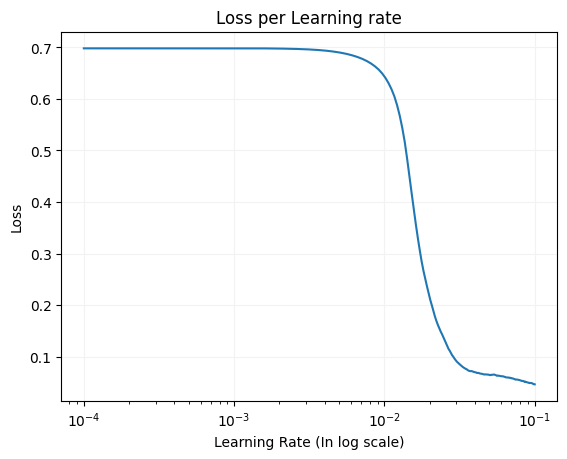

In [8]:
min_lr = 1e-4
max_lr = 1e-1
m_lr = AutoEncoderModel(mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def))
o_lr = mp.AdamWOptimizer(m_lr, lr=min_lr)
t_lr = mp.Trainer(m_lr, model_device, train_dl, val_dl)
lrs  = t_lr.find_lr(o_lr, max_lr, 200)
mplt.TrainPlot.plot_lr(lrs);

## Train

In [9]:
EPOCHS = 5

# First create a trainer.
trainer = mp.Trainer(model, model_device, train_dl, val_dl)
# Then an optimizer
optimizer = mp.AdamWOptimizer(model, lr=8e-3)
# Set up a OneCycle Scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer=optimizer.optimizer, 
            max_lr=optimizer.lr,
            steps_per_epoch=trainer.number_of_train_steps,
            epochs=EPOCHS
)

# Run the trainer for [EPOCH] epochs
history = trainer.train(EPOCHS, optimizer, scheduler)

Epoch 005/005: 100%|██████████| 3817/3817 [00:04<00:00, 942.12it/s, t_loss=0.0091, v_loss=0.0053]                              


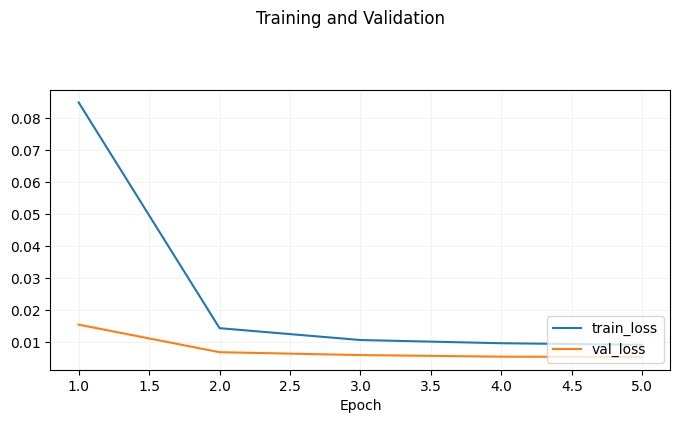

In [10]:
mplt.TrainPlot.plot_history(history, fig_size=(8,8));

## Testing the model

Here things get a bit more complicated, we now have a model that does not output a 'probability of fraud' between 0 and 1, rather it outputs a loss/reconstruction metric. The loss can range from 0 to -theoretically- infinity. And in this experiment we would hope that the loss/reconstruction metric is low for non-fraudulent transactions and it is high for fraudulent transactions. If so, we can seperate fraud from non-fraud by choosing a loss-threshold above which we consider a transaction fraud.

Remember, other than the training and validation dat set, the test data set still has transactions labeled **'fraud'**.


So first thing we might want to do is see if there is a sort of correlation between the loss metric and our fraud label. The first 2 diagrams will show.
- A Loss Histogram, with the loss on the x-axis. The loss is binned into 30 bins. And the number of entries with that loss on the y-axis. The series are the Fraud vs. Non Fraud. Important; the y-axis is in **Log scale** for readability, note that $10^5$ is 1000 times bigger than $10^2$.
- A set of performance metrics per threshold. These show us how the performance of the model would change if we increase or decrease the loss-threshold.

The first diagram shows that the model does somewhat sperate out the fraud from the non-fraud. More non-frauds get a lower reconstruction loss and on average it looks like the frauds get a higher reconstruction loss.

From the second diagram we can see that the Precision and Recall curve cross somewhere between the f1 and f2 peaking; at around a loss/reconstruction error threshold value of 0.1. That might be a good loss threshold to chose.

Calculating loss in 782 steps: 100%|████████| 782/782 [00:00<00:00, 1687.27it/s]


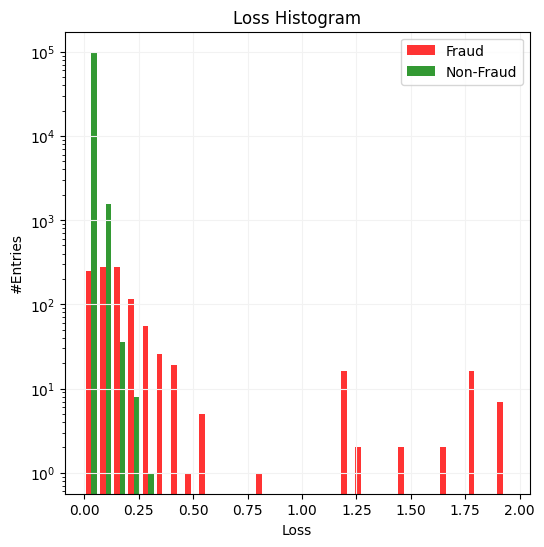

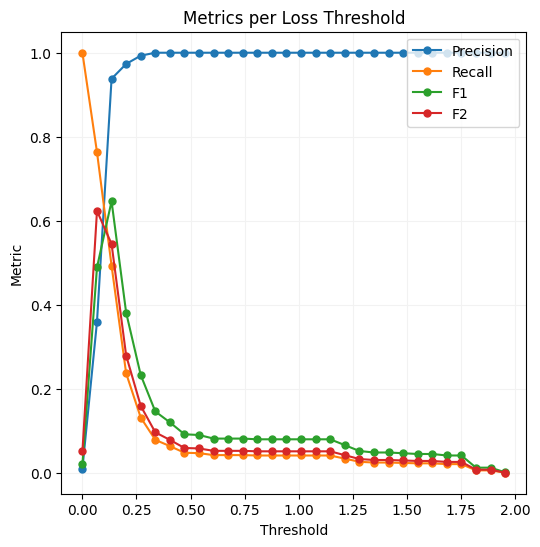

In [11]:
t = mp.Tester(model, model_device, test_dl)
results = t.test_results_loss()
mplt.TestPlot.plot_loss_binary(results, 30, fig_size=(6,6));
mplt.TestPlot.plot_loss_metrics(results, 30, fig_size=(6,6));

Let's run some estimations on how this model would perform if we use **0.1 as loss threshold**, (i.e. we assume anything about 0.1 is a fraud). The confusion matrix and classification report have a threshold we can feed. It the previous examples we did not provide the threshold, in which case the default 0.5 is used.

------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     98926
         1.0       0.77      0.59      0.67      1074

    accuracy                           0.99    100000
   macro avg       0.88      0.79      0.83    100000
weighted avg       0.99      0.99      0.99    100000


auc score : 0.9871
ap score  : 0.6962
-----------------------------------------------------


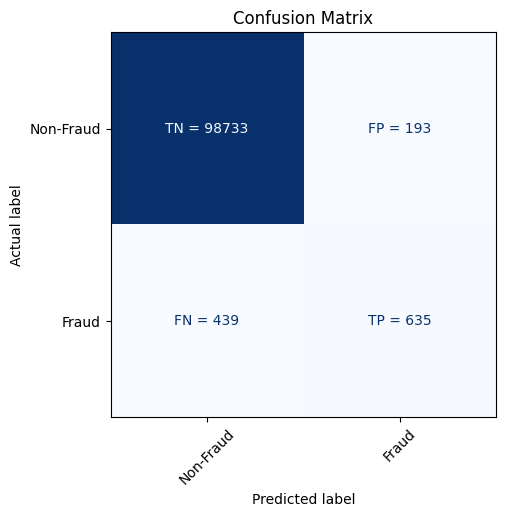

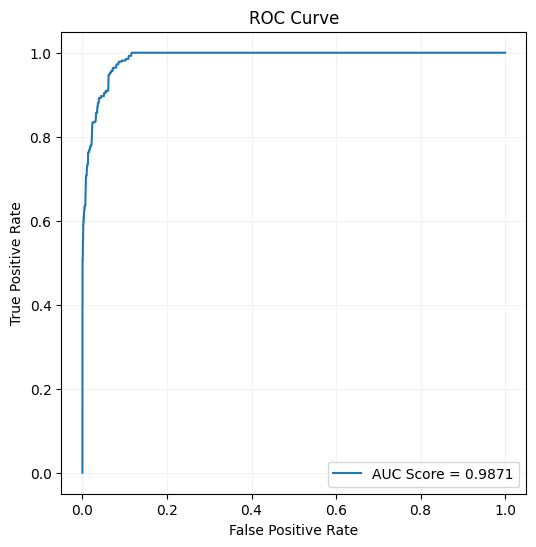

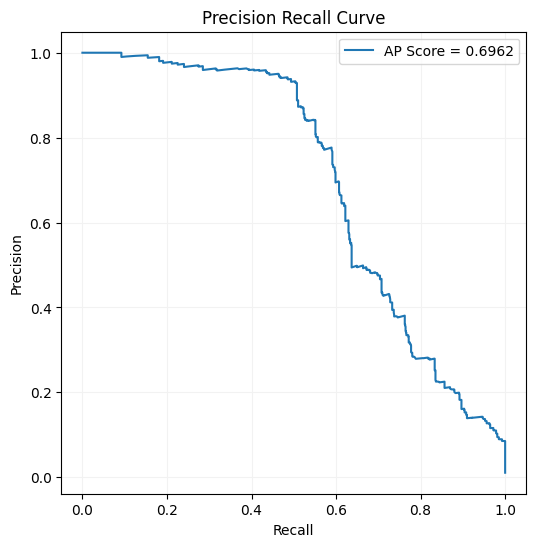

In [12]:
mplt.TestPlot.print_binary_classification_report(results, threshold=0.1)
mplt.TestPlot.plot_binary_confusion_matrix(results, fig_size=(5,5), threshold=0.1);
mplt.TestPlot.plot_roc_curve(results, fig_size=(6,6));
mplt.TestPlot.plot_precision_recall_curve(results, fig_size=(6,6))

## Visualizing the latent space.
We can have some fun trying to visualize what the latent space looks like. In order to do so, we will create a model that uses the `encoder` only, run some test data through and plot the output. Because we use the encoder only, our output will be the latent space, in our example it will consist of 3 points for each sample.

First we need to create a model with an encoder only. No decoder is defined for this model.

### Create model

In [13]:
class EncoderOnlyModel(mp.AutoEncoder):
    def __init__(self, model_configuration: mp.ModelConfiguration):
        # Always call init, it is very important to correctly initialize the nn.Module
        super(EncoderOnlyModel, self).__init__(model_configuration)
        self.encoder = self.create_linear_encoder(layer_sizes=(16, 3), dropout=0.1, bn_interval=0)

    def forward(self, x: Tuple[torch.Tensor, ...]) -> Tuple[torch.Tensor, ...]:
        # The forward creates the latent representation by calling the encoder.
        latent = self.encoder(x[0])
        return (latent,)
        
enc_model = EncoderOnlyModel(mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def))
enc_model

EncoderOnlyModel(
  Number of parameters : 1747. Loss : SingleLabelBCELoss,  mean
  (encoder): LinearEncoder(
    (layers): Sequential(
      (head): TensorDefinitionHead(Name=one-hot, lc=Binary)
      (linear_encoder): LinLayer(
        (layers): Sequential(
          (lin_layer_01): Linear(in_features=105, out_features=16, bias=True)
          (lin_act_01): ReLU()
          (lin_dropout_01): Dropout(p=0.1, inplace=False)
          (lin_layer_02): Linear(in_features=16, out_features=3, bias=True)
        )
      )
    )
  )
)

Then we copy across the parameters from the trained model into this model. At this point, we have a model that has the same encoder as the trained model, with the exact same parameters.

In [14]:
with torch.no_grad():
    enc_model.encoder.layers.linear_encoder.layers.lin_layer_01.weight.copy_(
        model.encoder.layers.linear_encoder.layers.lin_layer_01.weight
    )
    enc_model.encoder.layers.linear_encoder.layers.lin_layer_02.weight.copy_(
        model.encoder.layers.linear_encoder.layers.lin_layer_02.weight
    )

### Sample and Test data

Now let's do some sampling, this piece of code samples all the fraud from our test data set and a random sample of non-fraud.

In [15]:
N_FRAUD_SAMPLE_SIZE = 5000

# Get the labels
y = torch.squeeze(test_ds[:][1])
# First Separate out the Fraud from the Non-Fraud
fraud=test_ds[np.where(y==1.0)]
n_fraud=test_ds[np.where(y==0.0)]
# Now Sample a number of Non-Fraud records
sample_index = torch.randperm(n_fraud[0].shape[0])[:N_FRAUD_SAMPLE_SIZE]
n_fraud = n_fraud[0][sample_index]

Run both samples through the model and convert to numpy

In [16]:
enc_model.eval()
with torch.no_grad():
    nf = enc_model((n_fraud,))[0].detach().numpy()
    f  = enc_model((fraud))[0].detach().numpy()

### Plot Latent Space

Now we can plot the data. Red are the Fraud points, green are non-fraud points. We can see that the fraud is pretty much in the same location as the non-fraud. Spacially they do not seem to separate out in the latent space. After the 'encoding' most data seems to land pretty much in the same spacial area.

That is a bit of a shame. If we would get 2 fairly distinct areas for Fraud vs Non-Fraud, we could take some points from the 'Fraud' area, run them through the decoder and get new fraud records.

In later expermiments we should try to see what happens if we include fraud records in the training, maybe we might get more seperated out areas.

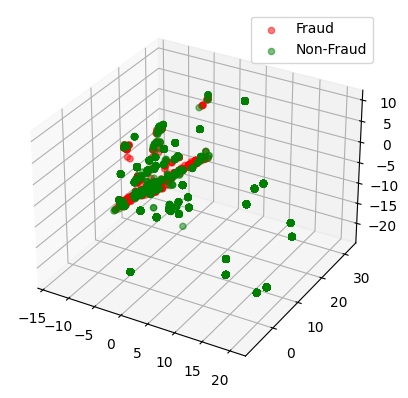

In [17]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for color, label, a in [('red', 'Fraud', f), ('green', 'Non-Fraud', nf)]:
    ax.scatter3D(a[:,0], a[:,1], a[:,2], color=color, label=label, alpha=0.5)
ax.legend()
ax.grid(True)
plt.show();

We were sort of lucky that we only had 3 latent dimensions, that makes it possible to visualize the latent space as-is. In case we would have more than 3 dimensions we could use a dimensionality reduction algorithm such as PCA or T-SNE or similar to reduced the dimensionality of the latent space.

Let's reduce the above to 2 dimensions, using PCA and visualise.

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
# PCA the combined non-fraud and fraud.
p = pca.fit_transform(np.concatenate((nf,f)))
pca.explained_variance_ratio_

array([0.43236378, 0.3456633 ], dtype=float32)

And then visualize the decomposed latent sapce. Again we see a fairly big overlap between the fraud and non-fraud. 

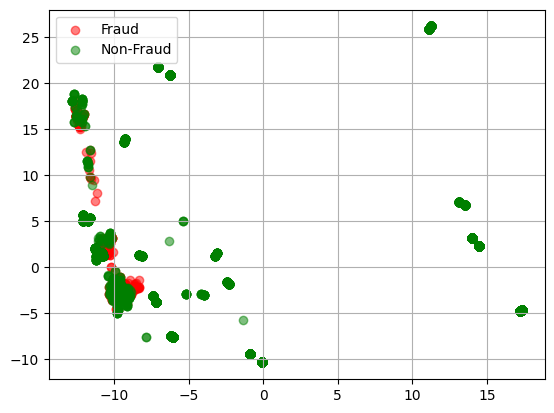

In [19]:
p_nf = p[:N_FRAUD_SAMPLE_SIZE]
p_f  = p[N_FRAUD_SAMPLE_SIZE:]
ax = plt.axes()
for color, label, a in [('red', 'Fraud', p_f), ('green', 'Non-Fraud', p_nf)]:
    ax.scatter(a[:,0], a[:,1], color=color, label=label, alpha=0.5)
plt.legend()
plt.grid(True)
plt.show()

## Conclusion
This was a first auto-encoder model, used in a sort of anomaly dection set-up. Its ability to detection fraud, even though it has never seen a fraud, nor does it know it is looking for fraud is even all that bad. 

Note however that we are looking for anomalies. In this case it turns out that anomalies are often fraud, but in real life this does not need to be the case. We could have frauds that look exactly like legit transactions and we could have anomalous transactions that are legit.